In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import pywt
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
import wave
from scipy.io import wavfile
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks, lfilter, sosfiltfilt

In [ ]:
drive.mount('/content/drive') # Change if needed
database_path = "" # Write the raw_database/ path
denoized_database_path = "" # Write the denoized_database/ path
databases_infos_path = "" # Write a directory path where you are reading and saving .xlsx files with databases informations.

Mounted at /content/drive


In [ ]:
database_info = pd.read_excel(os.path.join(databases_infos_path, "database_info.xlsx"))

In [ ]:
print(database_info)

    Unnamed: 0 Subject ID                             BPM  suposed_duration  \
0            0         f1                 132-148-150-150                40   
1            1         f2         150-147-152-150-148-150                60   
2            2         f3              []-142-130-135-136                50   
3            3         f4  []-152-144-142-143-138-135-131                80   
4            4         f5         150-156-156-154-158-155                60   
..         ...        ...                             ...               ...   
95          99        f97         145-140-145-144-150-145                60   
96         100        f98         138-132-131-129-132-133                60   
97         101        f99         136-135-131-138-142-145                60   
98         102       f100     126-127-131-125-130-144-125                70   
99         103       f101                 150-152-151-147                40   

    num_channels  sample_width  frame_rate  num_fra

In [ ]:
# Complete audio example
example_file_path = os.path.join(database_path, database_info['Subject ID'][0] + ".wav")

Tamanho da onda do áudio (y): (838121,)
Taxa de amostragem (sr): 16000


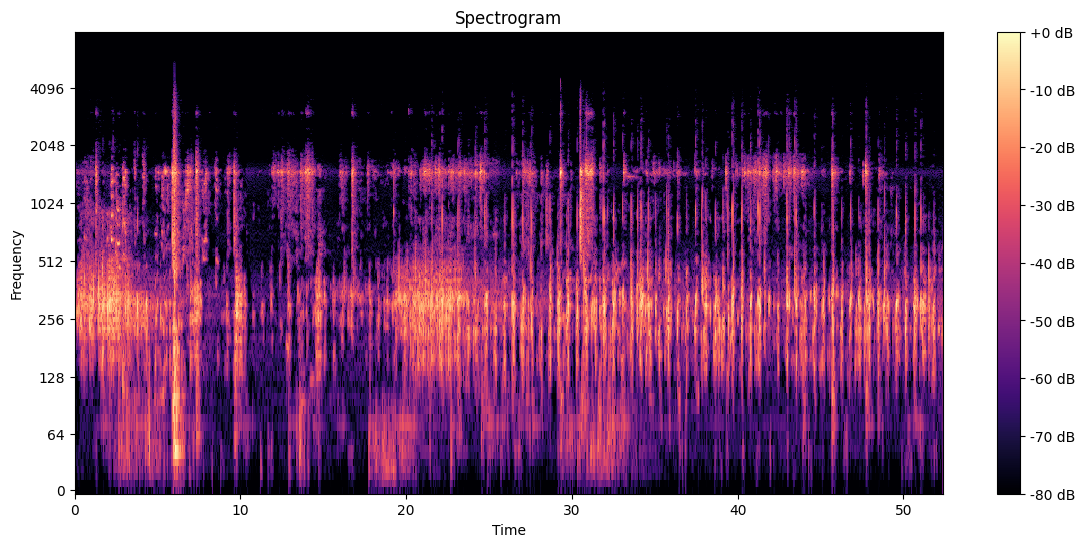

In [ ]:
# Spectogram example
y, sr = librosa.load(example_file_path)
sr = 16000
print(f'Audio wave size (y): {y.shape}')
print(f'Sample rate (sr): {sr}')

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

duration = librosa.get_duration(y=y, sr=sr)
ticks = range(0, int(duration)+1, 10)
plt.xticks(ticks, ticks) 

plt.show()

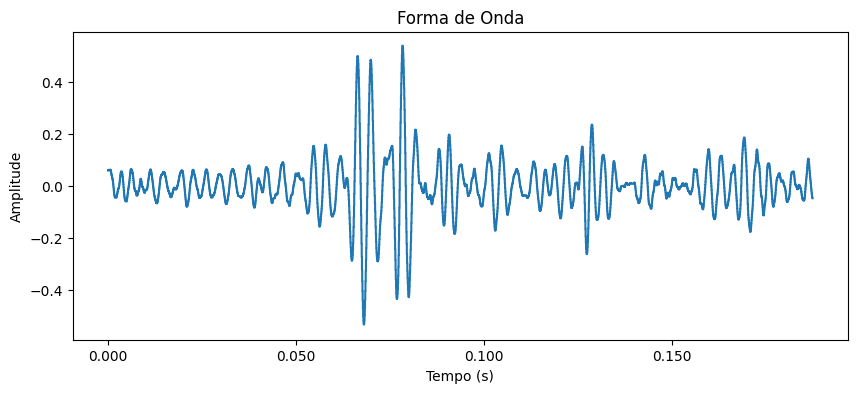

In [ ]:
# Wave form example
audio_data, sr = librosa.load(example_file_path)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_data[5000:8000], sr=16000)
plt.title('Forma de Onda')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.show()

Tamanho da onda do áudio (y): (160000,)
Taxa de amostragem (sr): 16000


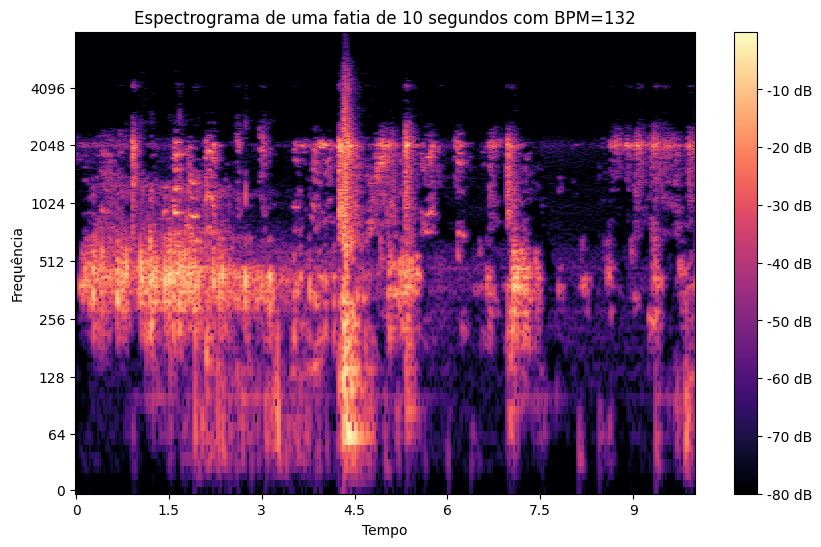

In [ ]:
# 10 seconds spectogram example
y, sr = librosa.load(example_file_path, sr=16000)

duracao = 10
y = y[:duracao * sr]

print(f'Audio wave size (y): {y.shape}')
print(f'Sample rate (sr): {sr}')

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('10 seconds spectogram with BPM=132')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Check if audio is normalized
def verify_normalization(subject_id):
  path_audio_completo = os.path.join(database_path, subject_id + ".wav")
  audio, sr = librosa.load(path_audio_completo, sr=16000)

  max_amplitude = np.max(np.abs(audio))

  if max_amplitude <= 1.0:
      return True
  else:
      return False

lista_nao_normalizados = []
for index, coluna in database_info.iterrows():
    if not verify_normalization(coluna['Subject ID']):
      lista_nao_normalizados.append(coluna['Subject ID'])

print(lista_nao_normalizados)


[]


### Filters

In [ ]:
def normalize_audio(data):
    max_amplitude = np.max(np.abs(data))
    normalized_data = data / max_amplitude  # Normalize between [-1, 1]
    return normalized_data

In [ ]:
def rescale_audio(data, mult=100):
    return data * mult  # Rescale between [-100, 100]

In [ ]:
def butter_bandpass_filter(data, lowcut=20, highcut=120, order=6, fs=16000):
    nyquist = 0.5 * fs # Nyquist ensures that the filter operates correctly within the limits of audible frequencies and prevents distortions during audio processing.
    low = lowcut / nyquist
    high = highcut / nyquist

    if not (0 < low < high < 1):
      raise ValueError("Invalid cutoff frequencies. Ensure that 0 < low < high < 1.")

    if not np.isfinite(data).all():
        raise ValueError("The input contains NaN or Inf values.")

    sos = butter(order, [low, high], btype='band', output='sos')
    y = sosfiltfilt(sos, data)

    if not np.isfinite(y).all():
        raise ValueError("The filter generated non-finite values (NaN or Inf) in the signal.")


    return y

In [ ]:
def estimate_sigma(detail_coeffs):
    return np.median(np.abs(detail_coeffs)) / 0.6745

def wavelet_filter(data, wavelet='coif4', level=7):
    coeffs = pywt.wavedec(data, wavelet, level=level) # wavelet decomposition
    sigma = estimate_sigma(coeffs[-1]) # Estimate the noise sigma using the detail coefficients at the first level
    threshold = sigma * np.sqrt(2 * np.log(len(data))) # Calculate the universal threshold
    thresholded_coeffs = coeffs.copy() # Apply soft thresholding to the detail coefficients
    for i in range(1, len(coeffs)):
        thresholded_coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')

    denoised_data = pywt.waverec(thresholded_coeffs, wavelet) # Reconstruct the signal using the thresholded coefficients


    denoised_data = denoised_data[:len(data)] # Truncate or pad the reconstructed signal to match the original length

    return denoised_data


In [ ]:
def apply_tranformations(file_path, transformations):
    data, sample_rate = librosa.load(file_path, sr=16000)

    transformed_data = data
    for transform in transformations:
        transformed_data = transform(transformed_data)

    return transformed_data

Assembling 10 second instances and placing them in a directory.

In [ ]:
# Delete the created files that are in the output folder.

# def apagar_conteudo_diretorio(diretorio):
#     # Verifica se o diretório existe
#     if os.path.exists(diretorio):
#         # Lista todos os arquivos e subdiretórios no diretório
#         for filename in os.listdir(diretorio):
#             file_path = os.path.join(diretorio, filename)
#             try:
#                 # Se for um arquivo ou link simbólico, apaga
#                 if os.path.isfile(file_path) or os.path.islink(file_path):
#                     os.unlink(file_path)
#                 # Se for um diretório, apaga recursivamente
#                 elif os.path.isdir(file_path):
#                     apagar_conteudo_diretorio(file_path)
#                     os.rmdir(file_path)  # Remove o diretório vazio
#             except Exception as e:
#                 print(f"Erro ao apagar {file_path}. Detalhes: {e}")
#     else:
#         print(f"O diretório {diretorio} não existe.")

# apagar_conteudo_diretorio(denoized_database_path)

In [ ]:
def separate_audio(subject_id, bpm_completo):
  lista_bpm = bpm_completo.split('-')


  path_audio_completo = os.path.join(database_path, subject_id + ".wav")
  audio = apply_tranformations(path_audio_completo, [normalize_audio, butter_bandpass_filter, wavelet_filter])

  duracao = 10 * sr

  ids = []
  bpms = []

  ponteiro_inicio_audio = 0
  contador_segmentos = 0
  for bpm in lista_bpm:
    if bpm != "[]":
      ponteiro_final_audio = ponteiro_inicio_audio + duracao
      segmento = audio[ponteiro_inicio_audio:ponteiro_final_audio]
      path_saida = os.path.join(denoized_database_path , f'{subject_id}_{contador_segmentos}_{bpm}.wav')
      sf.write(path_saida, segmento, sr)
      ids.append(f'{subject_id}_{contador_segmentos}')
      bpms.append(bpm)
      contador_segmentos += 1
    ponteiro_inicio_audio += duracao

  return pd.DataFrame({'ID': ids, 'BPM': bpms})



In [ ]:
lista_df_segmentos = []

for index, coluna in database_info.iterrows():
    df_segmentos = separate_audio(coluna['Subject ID'], coluna['BPM'])
    lista_df_segmentos.append(df_segmentos)

df = pd.concat(lista_df_segmentos, ignore_index=True)

In [ ]:
print(df.to_string())

          ID  BPM
0       f1_0  132
1       f1_1  148
2       f1_2  150
3       f1_3  150
4       f2_0  150
5       f2_1  147
6       f2_2  152
7       f2_3  150
8       f2_4  148
9       f2_5  150
10      f3_0  142
11      f3_1  130
12      f3_2  135
13      f3_3  136
14      f4_0  152
15      f4_1  144
16      f4_2  142
17      f4_3  143
18      f4_4  138
19      f4_5  135
20      f4_6  131
21      f5_0  150
22      f5_1  156
23      f5_2  156
24      f5_3  154
25      f5_4  158
26      f5_5  155
27      f6_0  138
28      f6_1  132
29      f6_2  135
30      f6_3  140
31      f6_4  132
32      f6_5  138
33      f6_6  143
34      f7_0  147
35      f7_1  144
36      f7_2  143
37      f7_3  142
38      f7_4  150
39      f7_5  151
40      f7_6  145
41      f8_0  137
42      f8_1  139
43      f8_2  132
44      f8_3  138
45      f8_4  132
46      f8_5  126
47      f8_6  128
48      f9_0  144
49      f9_1  142
50      f9_2  130
51      f9_3  147
52      f9_4  140
53     f10_0  168
54     f10

In [ ]:
def get_wav_info(file_name):
    with wave.open(file_name, 'rb') as wav_file:

        num_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        frame_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        duration = num_frames / frame_rate
        return num_channels, sample_width, frame_rate, num_frames, duration

In [ ]:
num_channels_list = []
sample_width_list = []
frame_rate_list = []
num_frames_list = []
duration_list = []

for index, coluna in df.iterrows():
    file_name = os.path.join(denoized_database_path, f"{coluna['ID'] + '_' + coluna['BPM']}.wav")
    num_channels, sample_width, frame_rate, num_frames, duration = get_wav_info(file_name)
    num_channels_list.append(num_channels)
    sample_width_list.append(sample_width)
    frame_rate_list.append(frame_rate)
    num_frames_list.append(num_frames)
    duration_list.append(duration)

df['num_channels'] = num_channels_list
df['sample_width'] = sample_width_list
df['frame_rate'] = frame_rate_list
df['num_frames'] = num_frames_list
df['duration'] = duration_list

In [ ]:
print(len(df))

631


In [ ]:
print(df.to_string())

          ID  BPM  num_channels  sample_width  frame_rate  num_frames  duration
0       f1_0  132             1             2       16000      160000    10.000
1       f1_1  148             1             2       16000      160000    10.000
2       f1_2  150             1             2       16000      160000    10.000
3       f1_3  150             1             2       16000      128160     8.010
4       f2_0  150             1             2       16000      160000    10.000
5       f2_1  147             1             2       16000      160000    10.000
6       f2_2  152             1             2       16000      160000    10.000
7       f2_3  150             1             2       16000      160000    10.000
8       f2_4  148             1             2       16000      160000    10.000
9       f2_5  150             1             2       16000      160000    10.000
10      f3_0  142             1             2       16000      160000    10.000
11      f3_1  130             1         

In [ ]:
print(df["num_channels"].value_counts())
print(df["sample_width"].value_counts())
print(df["frame_rate"].value_counts())
print(df["num_frames"].value_counts())
print(df["duration"].value_counts())

num_channels
1    631
Name: count, dtype: int64
sample_width
2    631
Name: count, dtype: int64
frame_rate
16000    631
Name: count, dtype: int64
num_frames
160000    621
138400      2
128160      1
134480      1
114720      1
14240       1
132160      1
122880      1
153920      1
117120      1
Name: count, dtype: int64
duration
10.000    621
8.650       2
8.010       1
8.405       1
7.170       1
0.890       1
8.260       1
7.680       1
9.620       1
7.320       1
Name: count, dtype: int64


In [ ]:
# Delete segments shorter than 10 seconds
instancias_com_pouca_duracao = df[df["duration"] < 10]

for index, coluna in instancias_com_pouca_duracao.iterrows():
  os.remove(os.path.join(denoized_database_path, f"{coluna['ID'] + '_' + coluna['BPM']}.wav"))
  df = df.drop(index)


In [ ]:
print(df["num_channels"].value_counts())
print(df["sample_width"].value_counts())
print(df["frame_rate"].value_counts())
print(df["num_frames"].value_counts())
print(df["duration"].value_counts())

num_channels
1    621
Name: count, dtype: int64
sample_width
2    621
Name: count, dtype: int64
frame_rate
16000    621
Name: count, dtype: int64
num_frames
160000    621
Name: count, dtype: int64
duration
10.0    621
Name: count, dtype: int64


In [ ]:
df.to_excel(os.path.join(databases_infos_path, "instances.xlsx"))